In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace
import math

# Cog Sci 132: Rhythms of the Brain 

## Assignment #1: Hudgkin-Huxley Model of Action Potentials

In this assignment, we are exploring the numerical approximation methods of the Hudgkin-Huxley model of the action potential. We will explore the effects of changing the inputs to the model, such as voltage-clamp, amplitude (of sine wave), time, frequency, etc. 

In the second part, we will take a look at how we can find error bounds for each method, and how said error bounds vary with the part of the action potential.
***
***
Table of Contents
- [Pre-defined Methods](#Methods)
- [Assignment Start](#Assignment#Starts#Here)
- [Question 1](#Q1)
- [Question 2](#Q2)
- [Question 3](#Q2)
- [Question 4](#Q4)

***
***
**By: Haya Halabieh**

## Methods

In [2]:
'''
The following class is defined for use of integration using numerical methods. The INTEGRATE method either 
uses Euler step or Runge-Kutta to integrate a function. 

Call _Integrator.integrate() to compute the integral of some function FUNC.
'''
def check_type(y,t): # Ensure Input is Correct
    return y.dtype == np.floating and t.dtype == np.floating

class _Integrator():
    
    def integrate(self,func,y0,t):
        time_delta_grid = t[1:] - t[:-1]
        
        y = np.zeros((y0.shape[0],t.shape[0]))
        y[:,0] = y0
        
        # Euler Step or Runge-Kutta Second Order Integration Step
        for i in range(time_delta_grid.shape[0]):
            y[:,i+1] = time_delta_grid[i]*func(y[:,i],t[i])+y[:,i] # Euler Integration Step
            
            #Un-Comment the next three lines to use the Runge-Kutta Second Order Integration
            #k1=(1/2)*time_delta_grid[i]*func(y[:,i],t[i])
            #breakpoint()
            #y[:,i+1] = y[:,i]+time_delta_grid[i]*func(y[:,i]+k1,t[i]+time_delta_grid[i]/2)
            
        return y
       
        #Runge-Kutta Fourth Order Integration Step
        #for i in range(time_delta_grid.shape[0]):
            #k1 = func(y[:,i], t[i])# RK4 Integration Steps replace Euler's Updation Steps
            #half_step = t[i] + time_delta_grid[i] / 2
            #k2 = func(y[:,i] + time_delta_grid[i] * k1 / 2, half_step)
            #k3 = func(y[:,i] + time_delta_grid[i] * k2 / 2, half_step)
            #k4 = func(y[:,i] + time_delta_grid[i] * k3, t + time_delta_grid[i])
            #y[:,i+1]= (k1 + 2 * k2 + 2 * k3 + k4) * (time_delta_grid[i] / 6) + y[:,i]
        #return y


def odeint_rk4(func,y0,t):
    y0 = np.array(y0)
    t = np.array(t)
    if check_type(y0,t):
        return _Integrator().integrate(func,y0,t)
    else:
        print("error encountered")

In [3]:
'''
The following variables are defined to be the membrane capacitance for the ions. 
K correpsonds to potassium, Na corresponds to sodium, L corresponds to Lithium.
'''
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

In [4]:
def f(x):
    
    if abs(x)<1e-12: 
        x=1
    elif x < -20:
        ex = np.exp(x)
        x = -x*ex/(1-ex)
    else: 
        x = x/(1-np.exp(-x))
    return x

def g(x):
    x = x/(np.exp(x)-1)
    return x

def h(x):
    if x < -20:
        x = np.exp(x)/(np.exp(x)+1)
    else: x = 1/(1+np.exp(-x))
    return x

def K_prop(v):

#αn(V ) = 0.032(V + 52)/(1 − exp(−(V + 52)/5))
    def alpha_n(v):
        u= (v+52)/5
        return 0.032*5*f(u)
    beta_n=0.5*np.exp(-(v+65)/80)

    def n_inf(v):
        return (alpha_n(v)/(alpha_n(v)+ beta_n))
        #set_trace()
    def tau_n(v):
        return (1/(alpha_n(v)+beta_n))
    #set_trace()
    return n_inf(v), tau_n(v)


def Na_prop(v):
    
#αm(V) = 0.32(V + 54)/(1 − exp(−(V + 54)/4))
#βm (V ) = 0.28(V + 27)/(exp((V + 27)/5) − 1)

    def alpha_m(v):
        u = (v+54)/4
        return 4*0.32*f(u)
    
    def beta_m(v):
        u =(v+27)/5
        return 5*0.28*g(u)

    def m_inf(v):
        return (alpha_m(v)/(alpha_m(v)+beta_m(v)))
    
    def tau_m(v):
        return (1 / (alpha_m(v) + beta_m(v)))

#αh(V) = 0.128 exp(−(V + 50)/18)
#βh(V) = 4/(1 + exp(−(V + 27)/5)

    alpha_h = 0.128*np.exp(-(v+50)/18)
                                 
    def beta_h(v):
        u = (v+27)/5
        return 4*h(u)
    
    def h_inf(v):
        return (alpha_h/(alpha_h+beta_h(v)))
    
    def tau_h(v):
        return 1/(alpha_h+beta_h(v))
    #set_trace()
    
    return m_inf(v), tau_m(v), h_inf(v), tau_h(v)


In [5]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

In [6]:
def gPot(n):
    return g_K * n**4

def gSod():
    return 

In [7]:
def run_HH(v_clamp):
    
    def dXdt(X,t):
        V = v_clamp
        #V = X[0:1]
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        #dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        # Here the current injection I_injected = 5 uA
        
        
        
        n0,tn = K_prop(V)
        #set_trace()
        m0,tm,h0,th = Na_prop(V)
        
        dmdt = - (1.0/tm)*(m-m0)
        dhdt = - (1.0/th)*(h-h0)
        dndt = - (1.0/tn)*(n-n0)

        out = np.concatenate([dmdt,dhdt,dndt],0)
        return out

    V=v_clamp
    epsilon = 0.01
    t = np.arange(0, 3, epsilon)
    y0 = np.float64([0,1,0])
    
    state = odeint_rk4(dXdt, y0, t)
    

    #V = state[3]
    m = state[0]
    h = state[1]
    n = state[2]
    
    i_na = I_Na(V, m, h)
    i_k = I_K(V, n)
    i_l = I_L(V)
    i_m = i_na + i_k + i_l
    
    fig, ax = plt.subplots(1)
    ax.set_title("Voltage Clamp = " + str(v_clamp) + " mV")
    ax.set_xlabel("Time")
    ax.plot(t, m**3, label = "m^3")
    ax.plot(t, h, label = "h")
    ax.plot(t, m**3*h, label= "m^3h")
    ax.legend()
    
    return

***
***
# Assignment Starts Here

## Q1

### Question 1a.
Replicate the fure in Ermentrout and Termoun. It is a voltage-clamp experiment, where the voltage is held at rest and then stepped up to a testing voltage. Step the voltage to 0, +30, +60 mV and show all the Na currents and the K currents. 

### Solution:

<ipython-input-2-b79b2e6ba0c5>:8: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


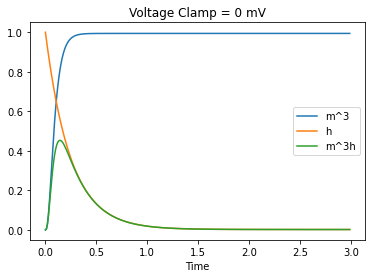

In [8]:
#voltage of 0 mV
run_HH(0)

<ipython-input-2-b79b2e6ba0c5>:8: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


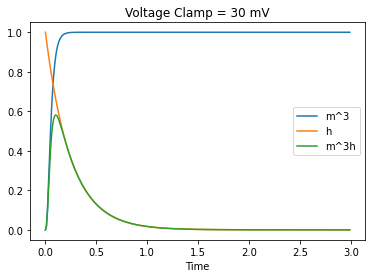

In [9]:
#voltage of 30 mV
run_HH(30)

<ipython-input-2-b79b2e6ba0c5>:8: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


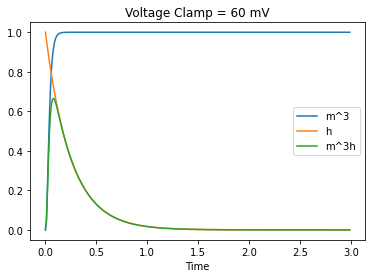

In [10]:
#voltage of 60 mV
run_HH(60)

### Question 1b. 
Explain the flow of Na ions in all traces. 

### Solution:

_Comparing the plot of 0 mV to +30 mV to +60 mV, we can see that the green curve, representing $m^3h$ has an activation peak that increases with the increase in voltage, directly. That also means the drop off, after the peak at 0.02 ms, has a steeper (more negative slope) as the voltage clamp increases._

_The 60 mV voltage clamp has the highest voltage reached, at around 0.7 mV._

## Q2
Create a plot where you show all the activation and inactivation cuves. In a seperate plot, show the time constants. 

### Solution:


#### Activation Equations
$$ X_{\infty}(V) = \frac{\alpha_x(V)}{\alpha_x(V) + \beta_x(V)}$$ and $$\tau_x(V) = \frac{1}{\alpha_x + \beta_x}$$

where X = {n, m, h}

On the left plot, there are overlayed activation curves. On the right plot, we see time constants.

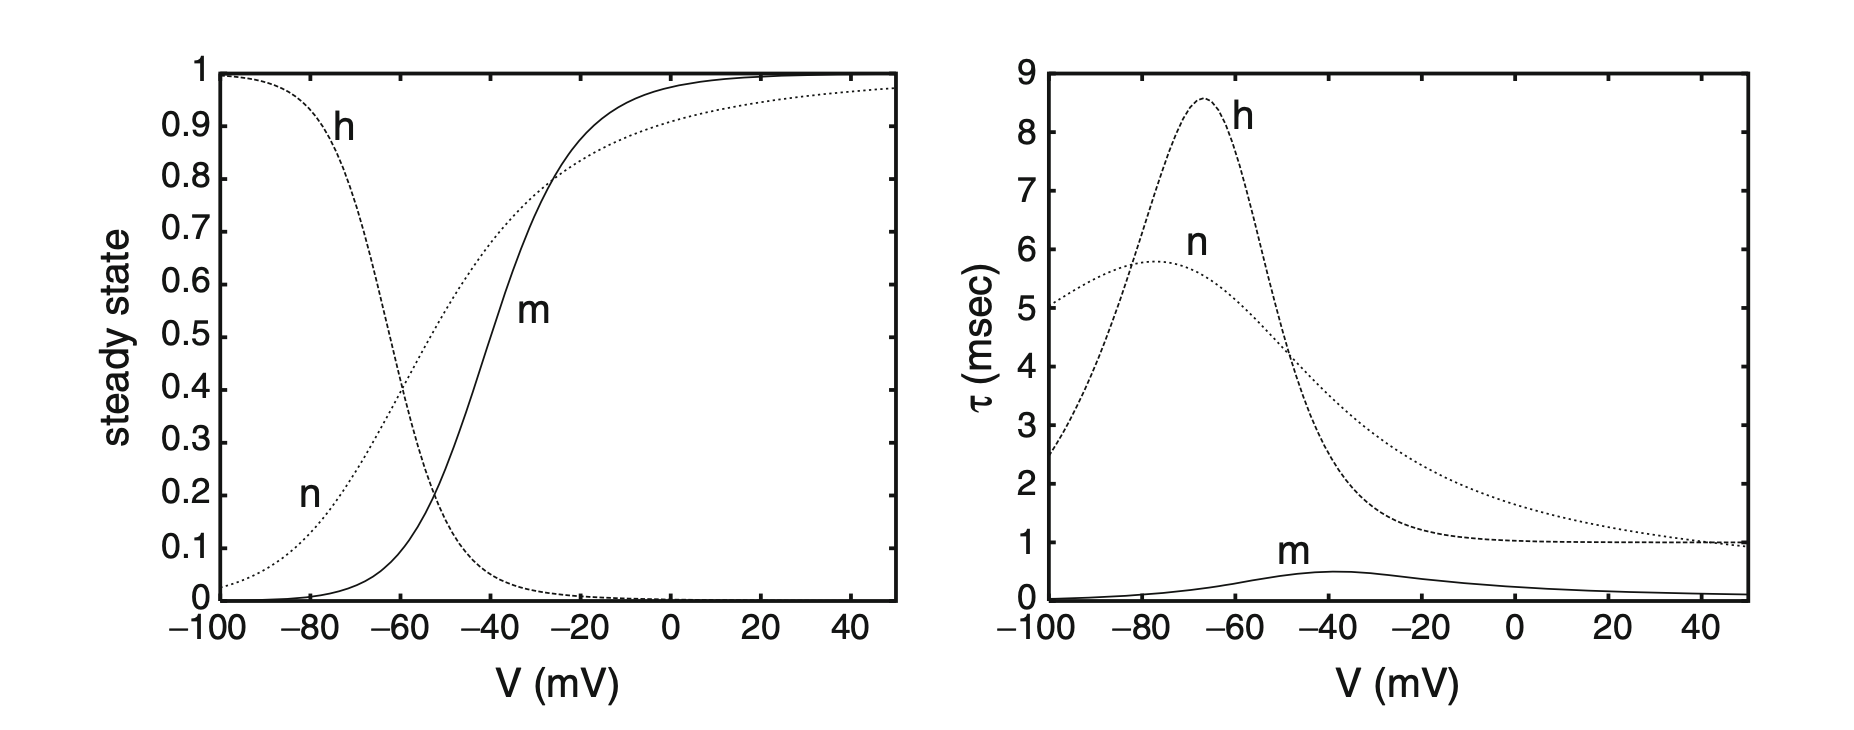

Note that $n_{\infty}(V)$ and $m_{\infty}(V)$ are increasing functions that approach 0 for hyperpolarizing currents and approach 1 for depolarizing currents.
Hence, $n_{\infty}(V)$ and $m_{\infty}(V)$ become activated when the membrane is depolarized. On the other hand, $h_{\infty}(V)$ is a decreasing function, so the sodium channels deactivate the membrane is depolarized.

In [11]:
def activation_time_plots(type):
    V = np.arange(-100, 40)
    
    def y_vals(volt_range):
        y_h, y_n, y_m, T_h, T_n, T_m = [], [], [], [], [], []
        
        for i in volt_range:
            n_inf, tau_n = K_prop(i)
            m_inf, tau_m, h_inf, tau_h = Na_prop(i)
            y_h.append(h_inf)
            y_n.append(n_inf)
            y_m.append(m_inf)
            T_h.append(tau_h)
            T_n.append(tau_n)
            T_m.append(tau_m)
        return y_h, y_n, y_m, T_h, T_n, T_m
    
    y_h, y_n, y_m, T_h, T_n, T_m = y_vals(V)
    
    if type == 'activation':
        #activation and inactivation plots
        fig, ax = plt.subplots(1)
        ax.set_title("Activation and Inactivation")
        ax.set_xlabel("V (mV)")
        ax.set_ylabel("steady state")
        ax.plot(V, y_m, label = "m", color = 'b')
        ax.plot(V, y_n, label = "n", color = 'y')
        ax.plot(V, y_h, label= "h", color = 'r')
        ax.legend()
   
    elif type == 'time_constraint':
        #time constraints plots
        fig, ax = plt.subplots(1)
        ax.set_title("Time Constraints")
        ax.set_xlabel("V (mV)")
        ax.set_ylabel("Tau (msec)")
        ax.plot(V, T_h, label = "h", color='r')
        ax.plot(V, T_n, label = "n", color = 'y')
        ax.plot(V, T_m, label= "m", color = 'b')
        ax.legend()
    else:
        print("Invalid argument passed into type")
    

    return


<ipython-input-4-83f1ef27bf32>:13: RuntimeWarning: invalid value encountered in double_scalars
  x = x/(np.exp(x)-1)


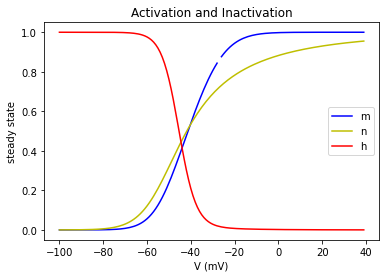

In [12]:
activation_time_plots('activation')

<ipython-input-4-83f1ef27bf32>:13: RuntimeWarning: invalid value encountered in double_scalars
  x = x/(np.exp(x)-1)


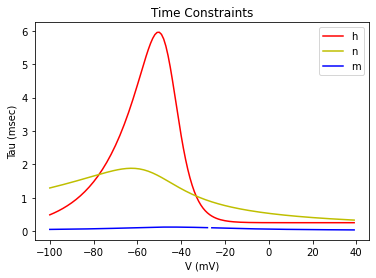

In [13]:
activation_time_plots('time_constraint')

## Q3
Solve the HH equations with a brief pulse of current that produces an action potential. 

Use a current stimulation that is $$sin(wt)$$ where $w$ is the frequency of the stimulation. Use frequencies between $ [10 hz, 1000 hz] $ corresponding to $$wT = 2\pi $$ and $$T = \frac 1 f$$ to show how the action potential is modulated. Change the amplitude of the sine wave to see the effect. 

### Solution:

Hodgking-Huxley model is a system of 4 differential equations. 

$$c_M \frac{dV}{dt} = -\bar{g}_{Na}m^3h(V-E_{Na})-\bar{g}_Kn^4(V-E_K) - \bar{g}_L(V-E_L)$$

$$\frac{dn}{dt} = \phi[\alpha_n(V)(1-n) - \beta_n(V)n]$$

$$\frac{dm}{dt} = \phi[\alpha_m(V)(1-m) - \beta_m(V)m]$$

$$\frac{dh}{dt} = \phi[\alpha_h(V)(1-h) - \beta_h(V)h]$$

Start with defining a function that will plot a sine wave depending on the passed in arguments: `amplitude` which should vary the height of the sine curve, `freq` which is the frequency of the sine wave (more precisely the angular frequency represented by the variable $\omega$ ) and `time_range` which is the course of time the sine wave is flowing over.

In [99]:
def plot_sine(amplitude, freq, time_range):
    fig, ax = plt.subplots(1)
    ax.set_title("Change in Amplitude of Sine Waves")
    ax.set_xlabel("Time (msec)")
    
    def sine_wave(amp, freq, time):
        y = amp*math.sin(freq*time)
        return y
    
    def y_curve(a, f, t):
        y = []
        for time in t:
            y.append(sine_wave(a, f, time))
        return y
    
    for amp in amplitude_range:
        ax.plot(time_range, y_curve(amp, freq, time_range), label='Amp = ' + str(amp))
        
    
    fig.legend(loc="lower right")
    
    return 

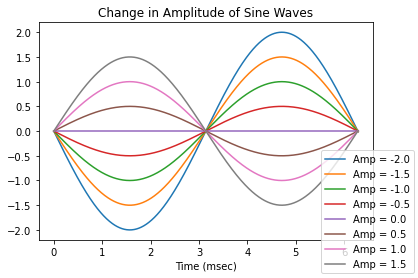

In [100]:
amplitude_range = np.arange(-2, 2, 0.5)
time_range = np.arange(0, 6.3, 0.01)

plot_sine(amplitude_range, 1, time_range)

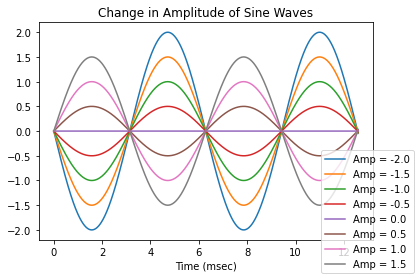

In [101]:
amplitude_range = np.arange(-2, 2, 0.5)
time_range = np.arange(0, 12.6, 0.01)

plot_sine(amplitude_range, 1, time_range)

We can modify the function `plot_sine` (or build on top of it) to use the sine wave as the x input to the Hodgkin-Huxley equations. 

The `HH_run()` function was throwing a lot of errors when I tried to input some `int` values, and as such I was unable to plot the HH solutions given sine wave inputs, however I showed my logic above

## Q4
Compare the accuracy of the Euler integration with the RK second order. Calculate an approximate error and use it to monitor the error as the action potential is generated. How does the error change in the Euler scheme in the different phases of the action potential?

### Solution:

Error bound on Euler's method (with $h = \frac T K$ as the step size): 
   
  -  Local error is defined by: $$\delta(k + 1) \leq e^{T}\frac{h^2}{2}$$ 
  
  - Global error is defined by: $$|\epsilon| \leq e^T(e^{kh} - 1)\frac h 2 \leq e^T(e^T - 1) \frac h 2$$
  
[Source Linked Here](https://ximera.osu.edu/laode/textbook/numericalSolutionsOfODEs/errorBoundsForEulersMethod)

Error bounds on Runge-Kutta method:

$$|f(x, y)| < M  ;   \frac{\partial^{i+j}f}{\partial x^i \partial y^i} < \frac {L^{i+1}}{M^{j-1}}$$ 

- Second Order error bound:
$$|E| < [4|(\frac 1 6 ) - \alpha_2| + \frac 1 3]ML^2$$

[Source Linked Here](https://www.ams.org/journals/mcom/1962-16-080/S0025-5718-1962-0150954-0/S0025-5718-1962-0150954-0.pdf)

In [103]:
'''
Functions to define the error bounds on the numerical methods. 

Class contains approximate error bounds for both Euler's method and Runge-Kutta 2nd order.
'''

class error_bounds():


    def euler_error(time, step_size, function):
        '''
        h = step_size
        function = y=f(x) to integrate over
        '''
        all_local_error = []
        for i in time:
            local_error = np.exp(time[i])*(step_size**2)/2
            all_local_error.append(local_error)
            
        T = time[len(time)-1]
        global_error = np.exp(T)*(np.exp(T)-1)*(step_size/2)
        return all_local_error, global_error
    
    def runge_kutta_error(alpha_2, M, L):
        '''
        alpha_2 = constant
        M is the bound of the function on the interval
        L is a constant that bounds the partial derivative
        '''
        inside = 4*abs((1/6) - alpha_2) + (1/3)
        val = inside * M * (L**2)
        return val
        

Without direct computation, the error bound of the Euler method as the action potential changes will depend on the linearity of the action potential. In other words, the depolarization and repolarization can be well-approximated through the Euler step method of integration for solving ODEs. But areas such as the peak of the depolarization (the max voltage reached) and the hypepolarization will have poor linear approximators, thus the error on the Euler method will increase at those places, and likely throughout the refractory period (as it has a hyperbolic shape). 

***

***